In [1]:
!pip install redshift-connector pandas --quiet

In [2]:
import sys
print("Python version:", sys.version)

# Check if pandas is working
try:
    import pandas as pd
    print("Pandas version:", pd.__version__)
except ImportError:
    print("Pandas not installed")

# Check for database connectors
try:
    import psycopg2
    print("psycopg2 is available")
except ImportError:
    print("psycopg2 not installed")

try:
    import redshift_connector
    print("redshift_connector is available")
except ImportError:
    print("redshift_connector not installed")

Python version: 3.10.18 | packaged by conda-forge | (main, Jun  4 2025, 14:45:41) [GCC 13.3.0]


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


Pandas version: 2.2.3
psycopg2 is available
redshift_connector is available


In [3]:
pip install pandas psycopg2-binary

Note: you may need to restart the kernel to use updated packages.


In [19]:
# You can either go by Redshift or S3

# For Redshift

import redshift_connector
import pandas as pd

# Connect to Redshift Serverless
conn = redshift_connector.connect(
    database='dev',  # your Redshift DB name
    user='admin',  # your username
    password='',  # your password
    is_serverless=True,
    serverless_acct_id='',  # your AWS account ID
    serverless_work_group='',  # your Redshift workgroup name
    region='us-east-1'  # Redshift region
)

# Run a query and load into a DataFrame
query = "SELECT * FROM fraudulent_returns"
df = pd.read_sql(query, conn)

# Preview the data
df.head()


In [4]:
# 1. Import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


In [5]:
import pandas as pd

# Replace with your actual S3 path
s3_path = 's3://.csv'

# Read the CSV directly from S3
df = pd.read_csv(s3_path)

# Preview the data
df.head()


/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/fsspec/registry.py:294: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


,customer_id,product_id,order_value,return_reason,return_count,damaged_flag,days_since_last_return,is_fraud
0,1102,19145,62.07,No Reason,2,1,173,0
1,1435,19494,50.46,Not Needed,3,0,3,0
2,1860,13381,114.03,No Reason,1,0,171,0
3,1270,15839,79.94,Damaged,4,0,91,0
4,1106,12880,131.24,No Reason,2,0,16,0


In [6]:
print("Shape:", df.shape)
print("Columns:", df.columns.tolist())
print(df.isnull().sum())


Shape: (10000, 8)
Columns: ['customer_id', 'product_id', 'order_value', 'return_reason', 'return_count', 'damaged_flag', 'days_since_last_return', 'is_fraud']
customer_id               0
product_id                0
order_value               0
return_reason             0
return_count              0
damaged_flag              0
days_since_last_return    0
is_fraud                  0
dtype: int64


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   customer_id             10000 non-null  int64  
 1   product_id              10000 non-null  int64  
 2   order_value             10000 non-null  float64
 3   return_reason           10000 non-null  object 
 4   return_count            10000 non-null  int64  
 5   damaged_flag            10000 non-null  int64  
 6   days_since_last_return  10000 non-null  int64  
 7   is_fraud                10000 non-null  int64  
dtypes: float64(1), int64(6), object(1)
memory usage: 625.1+ KB
None
        customer_id   product_id   order_value  return_count  damaged_flag  \
count  10000.000000  10000.00000  10000.000000  10000.000000  10000.000000   
mean    1503.470600  14996.09610     99.835366      2.007700      0.211500   
std      289.724434   2889.55972     29.483633      1.424726

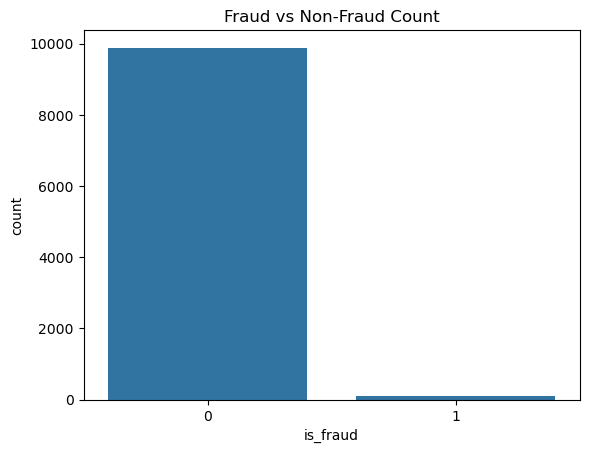

In [7]:
# 3. Basic EDA
print(df.info())
print(df.describe())
print(df['is_fraud'].value_counts())

# Check for nulls
print(df.isnull().sum())

# Optional: Visualize class distribution
sns.countplot(data=df, x='is_fraud')
plt.title("Fraud vs Non-Fraud Count")
plt.show()


In [8]:
# Remove rows with negative order_value
df = df[df['order_value'] > 0]



In [9]:
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']


In [10]:
print("Shape:", df.shape)
print("Class distribution:\n", df['is_fraud'].value_counts())

# Check for nulls
print("\nMissing values:\n", df.isnull().sum())


Shape: (9999, 8)
Class distribution:
 is_fraud
0    9887
1     112
Name: count, dtype: int64

Missing values:
 customer_id               0
product_id                0
order_value               0
return_reason             0
return_count              0
damaged_flag              0
days_since_last_return    0
is_fraud                  0
dtype: int64


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Separate features and target
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

# One-hot encode 'return_reason'
cat_features = ['return_reason']
preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore'), cat_features)],
    remainder='passthrough'
)

# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)


In [12]:
from imblearn.over_sampling import SMOTE

# Fit preprocessor to training data
X_train_encoded = preprocessor.fit_transform(X_train)

# SMOTE to balance
sm = SMOTE(random_state=42)
X_train_res, y_train_res = sm.fit_resample(X_train_encoded, y_train)


In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix

# Train the model
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_res, y_train_res)

# Transform X_test the same way you did for X_train
X_test_encoded = preprocessor.transform(X_test)

# Predict on test set
y_pred = clf.predict(X_test_encoded)

# Evaluation
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

print("\nConfusion Matrix:\n")
print(confusion_matrix(y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1978
           1       1.00      1.00      1.00        22

    accuracy                           1.00      2000
   macro avg       1.00      1.00      1.00      2000
weighted avg       1.00      1.00      1.00      2000


Confusion Matrix:

[[1978    0]
 [   0   22]]


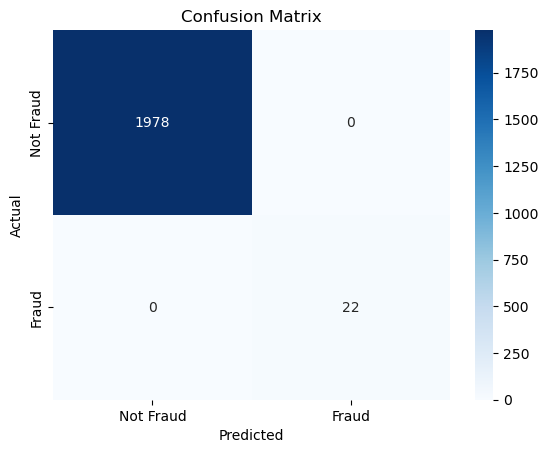

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


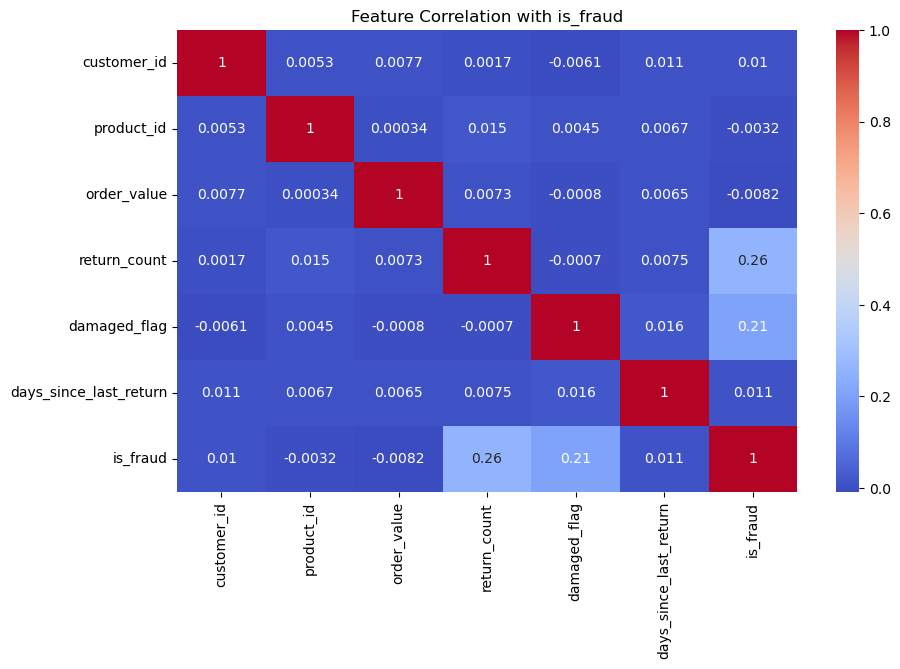

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation heatmap
corr = df.corr(numeric_only=True)
plt.figure(figsize=(10,6))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Feature Correlation with is_fraud")
plt.show()


In [16]:
print(df.groupby('is_fraud')['damaged_flag'].value_counts(normalize=True))
print(df.groupby('is_fraud')['return_reason'].value_counts(normalize=True))


is_fraud  damaged_flag
0         0               0.797512
          1               0.202488
1         1               1.000000
Name: proportion, dtype: float64
is_fraud  return_reason
0         Not Needed       0.255487
          Wrong Item       0.250329
          No Reason        0.248104
          Damaged          0.246081
1         Wrong Item       0.294643
          Damaged          0.267857
          No Reason        0.232143
          Not Needed       0.205357
Name: proportion, dtype: float64
